In [82]:
#Import everything needed for the project

import numpy as np
import cv2
import pickle
import glob, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
from scipy.misc import imresize
import math


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [83]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)

    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # To avoid error messages due to diving by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    
    
    return s_binary




# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [84]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

In [85]:
def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= hls_select(img, thresh=(50, 255))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(200, 250))

    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    

In [86]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


In [87]:
def undistortion(img, mtx, dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

In [88]:
#Function to obtain a warped image

def warp(img, src, dst,image_size):  
        
    #Get the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform (M)
    warped = cv2.warpPerspective(img, M, (image_size[1],image_size[0]),  flags=cv2.INTER_LINEAR)   
    

    return warped, M, Minv

In [124]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [125]:
def guided_search(image, warped, recent_xfitted):
    '''Obtain the coordinates of the pixels of a 
    line starting at the same center of the last detected line, 
    avoids to do the sliding window.'''
    
    OFFSET = 30
    y_pixels = []
    x_pixels = []
    all_xlast_fitted = []
    all_ylast_fitted = []
    y_list = []
    x0_list = []

    for index_y in range(image.shape[0]-1,-1,-1):

        x_last_fit = int(recent_xfitted[int(index_y/7.2)])

            
        if x_last_fit - OFFSET < 0:
            x0 = 0
        else:
            x0 = x_last_fit - OFFSET
        
        if x_last_fit + OFFSET >= image.shape[1]:
            x1 = image.shape[1]
        else:
            x1 = x_last_fit + OFFSET

        for x_index in range(x0,x1):
            if warped[index_y][x_index] == 1:                   
                x_pixels.append(x_index)
                y_pixels.append(index_y)

    
    return x_pixels, y_pixels
        
                    

In [126]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #slope for detected line
        self.slope = None
        #position car
        self.position = 0 
        
    
    
    def push_line(self, yvals, allx, ally):       
        '''A new line was detected so all the attributes need to be updated'''
        self.detected = True
        self.allx = allx
        self.ally = ally
        
        y_eval = np.max(yvals)
        
        
        
        side_fit = Line.calculate_polyfit(ally, allx)        
        self.current_fit = side_fit    
        
        xvals = Line.calculate_xvalues(yvals, side_fit)
        
        self.calculate_average_xvalues(np.array(xvals))
        
        
        side_curverad = Line.calculate_curvature_pixels(side_fit, y_eval)
        self.radius_of_curvature = side_curverad
        
        self.slope = Line.calculate_slope(self.allx[0], self.allx[-1], self.ally[0],self.ally[-1])
        
        
    
    
        
    def get_curvature_meters(self, yvals, y_eval, ym_per_pix = 30/720, xm_per_pix = 3.7/700 ):
        ''' 
        ym_per_pix: meters per pixel in y dimension
        xm_per_pix: meteres per pixel in x dimension
        '''
        
        side_fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        side_curverad = ((1 + (2*side_fit_cr[0]*y_eval + side_fit_cr[1])**2)**1.5) \
                            /np.absolute(2*side_fit_cr[0])
            
            
        return side_curverad
    
    
    def calculate_average_xvalues(self, xvals, n=5):
        self.recent_xfitted.append(xvals)
        
        if len(self.recent_xfitted) < n:
            n_last = self.recent_xfitted
        else:
            n_last = self.recent_xfitted[-n:]
            
        self.recent_xfitted = n_last
        self.bestx = np.mean(n_last, axis=0)

    @staticmethod
    def calculate_polyfit(ally, allx):
        coefficients = np.polyfit(ally, allx, 2)
        
        return coefficients
    
    
    @staticmethod
    def calculate_xvalues(yvals, side_fit):
        xvals = side_fit[0]*yvals**2 + side_fit[1]*yvals + side_fit[2]
        return xvals
    
    @staticmethod
    def calculate_curvature_pixels (side_fit, y_eval):
        curvature_pixels = ((1 + (2*side_fit[0]*y_eval + side_fit[1])**2)**1.5) \
                             /np.absolute(2*side_fit[0])
        
        return curvature_pixels
    
    @staticmethod
    def calculate_slope(x0,x1,y0,y1):
        slope = (y1-y0)/(x1-x0)
        return slope

In [127]:
def process_video(image, left_lane, right_lane,name_image):  
    '''Takes the image of the video and two instances of the Line class'''
    
    image_size = image.shape
    
    horizon = np.uint(2*image_size[0]/3)
    bottom = np.uint(image_size[0])
    center_lane = np.uint(image_size[1]/2)
    offset = 20

    x_left_bottom = 0
    x_right_bottom = 2*center_lane
    x_right_upper = center_lane +  center_lane/4.5
    x_left_upper = center_lane + offset - center_lane/5


    source = np.float32([[x_left_bottom,bottom],[x_right_bottom,bottom],[x_right_upper,horizon],[x_left_upper,horizon]])

    destination = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],
                  [image_size[1],0],[0,0]])

    
    
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    y_eval = np.max(yvals)
    
    image_undis = undistortion(image, mtx, dist)
    image_size = image_undis.shape
    warped, M, Minv =  warp(image_undis,source,destination, image_size)

    warped = pipeline_gradx_hls(warped)
    
    
    HEIGHT = range(image.shape[0]-1,0, -100)

    x_pixels, y_pixels, x_pixels_r, y_pixels_r, out_img = find_lane_pixels(warped)
    
    #LEFT LANE
    if not left_lane.detected:
        new_line_detected_left = Line()
        
        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))
    else:

        new_line_detected_left = Line()
        x_pixels, y_pixels = guided_search(image, warped, left_lane.recent_xfitted[-1])
        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))

        

    #RIGTH LANE
    if not right_lane.detected:
        new_line_detected_right = Line()
        
        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))
        
        
    else: 
        
        new_line_detected_right = Line()
        x_pixels_r, y_pixels_r =guided_search(image, warped, right_lane.recent_xfitted[-1])
        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))
         

    
    if new_line_detected_left.detected and new_line_detected_right.detected:
        check_slope = 1 < abs(new_line_detected_left.slope)
        check_slope = 1 < abs(new_line_detected_right.slope) and check_slope
        check_curve = new_line_detected_left.radius_of_curvature > 1100
        check_curve = new_line_detected_right.radius_of_curvature > 1100 and check_curve
        
        check_distance = True
        for index in range(len(new_line_detected_left.recent_xfitted[-1])):
            distance =new_line_detected_left.recent_xfitted[-1][index]-new_line_detected_right.recent_xfitted[-1][index]
            
            if (abs(distance)) < 600:            
                check_distance = False
        

        if check_slope and check_curve and check_distance:

        
            left_lane.push_line(yvals, new_line_detected_left.allx,new_line_detected_left.ally)
            left_lane.detected = True
        
            right_lane.push_line(yvals,new_line_detected_right.allx, new_line_detected_right.ally) 
            right_lane.detected = True
            
            
            CENTER = image.shape[1]/2
            xm_per_pix = 3.7/700
        
            lanes_middle_distance = abs(right_lane.recent_xfitted[-1][0] + left_lane.recent_xfitted[-1][0])/2
            
            position_car_pixels = abs(CENTER - lanes_middle_distance )
            position_car_meters = position_car_pixels *xm_per_pix
            left_lane.position = position_car_meters
 
        
    else:
        left_lane.detected = False
        right_lane.detected = False

    #Drawing the lines back down onto the road
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    # Recast the x and y points into usable format for cv2.fillPoly()

    left_msg = ''
    right_msg = ''
    position_msg = ''
    
    font = cv2.FONT_HERSHEY_COMPLEX
    if left_lane.bestx is not None and right_lane.bestx is not None:
        pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, yvals])))])
        pts = np.hstack((pts_left, pts_right))
        
        
        left_msg = 'Left curvature: '+ str(np.round(left_lane.get_curvature_meters(yvals, y_eval)))+'m'
        right_msg = 'Right curvature: '+ str(np.round(left_lane.get_curvature_meters(yvals, y_eval)))+'m'
        position_msg = 'Car position:' + str(round(left_lane.position,3)) + 'm'
        
    # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image_undis, 1, newwarp, 0.3, 0)

    cv2.putText(result, left_msg, (30, 60), font, 1, (0,0,0), 2)
    cv2.putText(result, right_msg, (800, 60), font, 1, (0,0,0), 2)
    cv2.putText(result, position_msg, (500, 550), font, 1, (0,0,0), 2)

    return result
           

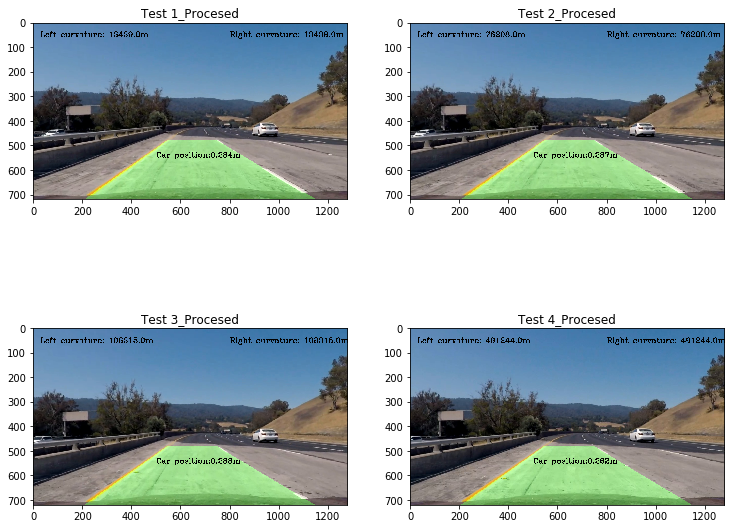

In [128]:
#Only for testing
images_proccesed =[]
images = glob.glob('frames_test/*.jpg')
images.sort()

left_lane = Line()
right_lane = Line()
for idx, image_name in enumerate(images):
    name = image_name.split('/')
    img =  mpimg.imread(image_name)
    procesed= process_video(img, left_lane, right_lane,name )
    images_proccesed.append(procesed)
    

n_row = 2
n_col = 2
show_images(images_proccesed,n_row,n_col,"Procesed")


In [129]:
#ensures that old instances are deleted
del(left_lane)
del(right_lane)

#creates new instances with default values
left_lane = Line()
right_lane = Line()

def wrapper(image):
    """wrapper to send 2 intances of the Line class to the function process_video()"""
    global left_lane
    global right_lane
    result = process_video(image, left_lane, right_lane, '')
    return result

In [131]:
#To process the video 
output = 'project_video_result.mp4'
file = VideoFileClip("project_video.mp4");

out = file.fl_image(wrapper) #NOTE: this function expects color images!!
%time out.write_videofile(output, audio=False);

[MoviePy] >>>> Building video project_video-result.mp4
[MoviePy] Writing video project_video-result.mp4



 12%|█▏        | 153/1261 [00:37<04:39,  3.97it/s]


 24%|██▍       | 304/1261 [01:14<03:50,  4.16it/s]


 36%|███▌      | 455/1261 [01:52<03:45,  3.57it/s]


 48%|████▊     | 606/1261 [02:31<02:45,  3.95it/s]


 60%|██████    | 757/1261 [03:09<02:05,  4.01it/s]


 72%|███████▏  | 908/1261 [03:48<01:29,  3.95it/s]


 84%|████████▍ | 1058/1261 [04:29<00:53,  3.83it/s]


 96%|█████████▌| 1206/1261 [05:08<00:14,  3.93it/s]


100%|█████████▉| 1260/1261 [05:22<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video-result.mp4 

CPU times: user 6min 20s, sys: 13.3 s, total: 6min 34s
Wall time: 5min 23s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))